In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D,Activation,BatchNormalization,Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping


import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
train_dir = "dataset/train"
validate_dir = "dataset/validate"

In [4]:
num_of_train_sample=0
num_of_validate_sample=0

for labels in os.listdir(train_dir):
    for i in os.listdir(os.path.join(train_dir,labels)):
        num_of_train_sample+=1
        
for labels in os.listdir(validate_dir):
    for i in os.listdir(os.path.join(validate_dir,labels)):
        num_of_validate_sample+=1
        
print(num_of_train_sample,num_of_validate_sample)
        

24256 3006


In [5]:
train_image_generator = ImageDataGenerator(rescale=1./255,
                                           rotation_range=30,
                                           horizontal_flip=True,
                                           zoom_range=0.5)

validate_image_generator = ImageDataGenerator(rescale=1./255,
                                             rotation_range=30,
                                             horizontal_flip=True,
                                             zoom_range=0.5)

In [17]:
batch_size = 32
image_height = 48
image_width = 48
num_of_class = 5
epoch = 50

train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                          directory=train_dir,
                                                          shuffle=True,
                                                          target_size=(image_width,image_height),
                                                           class_mode='categorical',
                                                          color_mode='grayscale')

val_data_gen = validate_image_generator.flow_from_directory(batch_size=batch_size,
                                                          directory=validate_dir,
                                                          shuffle=True,
                                                          target_size=(image_width,image_height),
                                                           class_mode='categorical',
                                                           color_mode='grayscale')


Found 24256 images belonging to 5 classes.
Found 3006 images belonging to 5 classes.


In [7]:
samples,labels = next(train_data_gen)
np.argmax(labels[4])

2

1
0
4
4
1


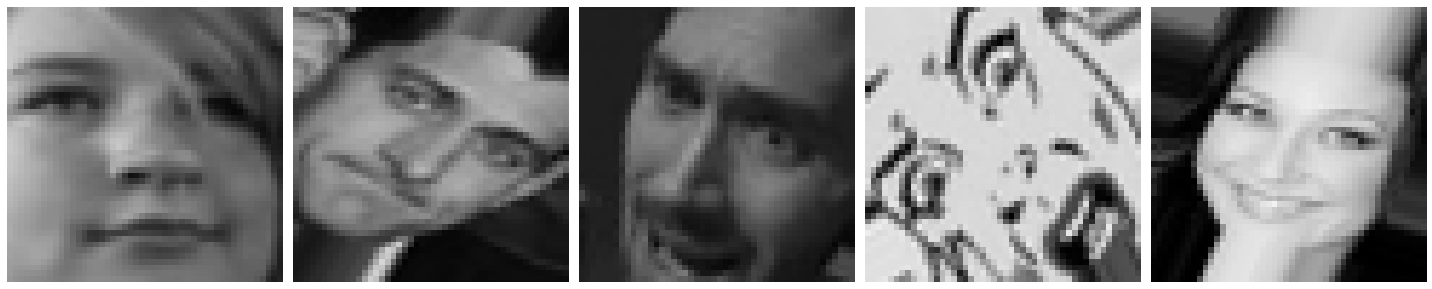

In [49]:
fig,axes = plt.subplots(1,5,figsize=(20,20))

for img,ax,l in zip(samples[:5],axes,labels):
    ax.imshow(img)
    ax.axis('off')
    print(np.argmax(l))
plt.tight_layout()
plt.show()

# model

In [23]:
model = Sequential()

#first conv layer
model.add(Conv2D(filters=32,kernel_size=(3,3),padding='same',kernel_initializer='he_normal',input_shape=(image_width,image_height,1)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Dropout(0.2))


#second conv layer
model.add(Conv2D(filters=64,kernel_size=(3,3),padding='same',kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=64,kernel_size=(3,3),padding='same',kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Dropout(0.2))

#3rd conv layer
model.add(Conv2D(filters=128,kernel_size=(3,3),padding='same',kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=128,kernel_size=(3,3),padding='same',kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Dropout(0.2))

#4th conv layer
model.add(Conv2D(filters=256,kernel_size=(3,3),padding='same',kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=256,kernel_size=(3,3),padding='same',kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Dropout(0.2))


#4th conv layer
model.add(Conv2D(filters=512,kernel_size=(3,3),padding='same',kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=512,kernel_size=(3,3),padding='same',kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Dropout(0.2))


#1st FC
model.add(Flatten())
model.add(Dense(units=512,kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

#2nd FC
model.add(Dense(units=512,kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

#classifier layers
model.add(Dense(units=num_of_class,kernel_initializer='he_normal'))
model.add(Activation('softmax'))


In [24]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 48, 48, 32)        320       
_________________________________________________________________
activation_42 (Activation)   (None, 48, 48, 32)        0         
_________________________________________________________________
batch_normalization_38 (Batc (None, 48, 48, 32)        128       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 24, 24, 32)        0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 24, 24, 64)        18496     
_________________________________________________________________
activation_43 (Activation)   (None, 24, 24, 64)       

In [25]:
opt = Adam(lr=0.001)
model.compile(optimizer=opt,loss=tf.keras.losses.categorical_crossentropy,metrics=['accuracy'])

In [26]:
def scheduler(epoch):
    if epoch < 10:
        return 0.001
    else:
        return float(0.001 * tf.math.exp(0.1 * (10 - epoch)))
    
lrSchedualer = tf.keras.callbacks.LearningRateScheduler(scheduler)

checkpoint = ModelCheckpoint("emotion_recogtion.h5",monitor='val_accuracy',verbose=1,save_best_only=True,save_weights_only=False,mode='auto',period=1)



#early = EarlyStopping(monitor='val_loss',min_delta=0,patience=20,verbose=1,mode='auto')]


hist = model.fit_generator(generator=train_data_gen,steps_per_epoch=(num_of_train_sample//batch_size),validation_data=val_data_gen,validation_steps=(num_of_validate_sample//batch_size),epochs=epoch,callbacks=[checkpoint,lrSchedualer])

Epoch 1/50
757/758 [============================>.] - ETA: 1s - loss: 1.9207 - accuracy: 0.2493
Epoch 00001: val_accuracy improved from -inf to 0.28327, saving model to emotion_recogtion.h5
758/758 [==============================] - 876s 1s/step - loss: 1.9205 - accuracy: 0.2492 - val_loss: 1.6215 - val_accuracy: 0.2833
Epoch 2/50
757/758 [============================>.] - ETA: 1s - loss: 1.5847 - accuracy: 0.3018
Epoch 00002: val_accuracy improved from 0.28327 to 0.33669, saving model to emotion_recogtion.h5
758/758 [==============================] - 869s 1s/step - loss: 1.5848 - accuracy: 0.3018 - val_loss: 1.5272 - val_accuracy: 0.3367
Epoch 3/50
757/758 [============================>.] - ETA: 1s - loss: 1.4972 - accuracy: 0.3481
Epoch 00003: val_accuracy improved from 0.33669 to 0.34140, saving model to emotion_recogtion.h5
758/758 [==============================] - 869s 1s/step - loss: 1.4971 - accuracy: 0.3482 - val_loss: 1.5565 - val_accuracy: 0.3414
Epoch 4/50
757/758 [========

KeyboardInterrupt: 